<a href="https://colab.research.google.com/github/XueqingWu/Explainable_AI_Global_Explanation/blob/main/Global_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install shap==0.45.1
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-9oetuapx/alepython_56aa3d9ddb4a4e9bae148a52589c0c54
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-9oetuapx/alepython_56aa3d9ddb4a4e9bae148a52589c0c54
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done


In [2]:

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn import metrics

# Models
import xgboost
from sklearn.model_selection import train_test_split

# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(13)

## Load Data

In [3]:

# load dataset
from sklearn.datasets import load_iris

iris = load_iris()
# convert to dataframe
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df
# # Subset data to two classes
iris_df = iris_df[iris.target != 2]
iris_df["target"] = iris.target[iris.target != 2]
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


In [4]:
from sklearn.model_selection import train_test_split

# Assuming iris_df is your DataFrame and target is the column you want to predict
y = iris_df["target"]  # Target variable
X = iris_df.drop("target", axis=1)

The dataset is the iris data from sklearn package. It contains 2 types of iris, with features including sepal width, sepal length, petal width, and petal lengh.

## Exploratory Analysis

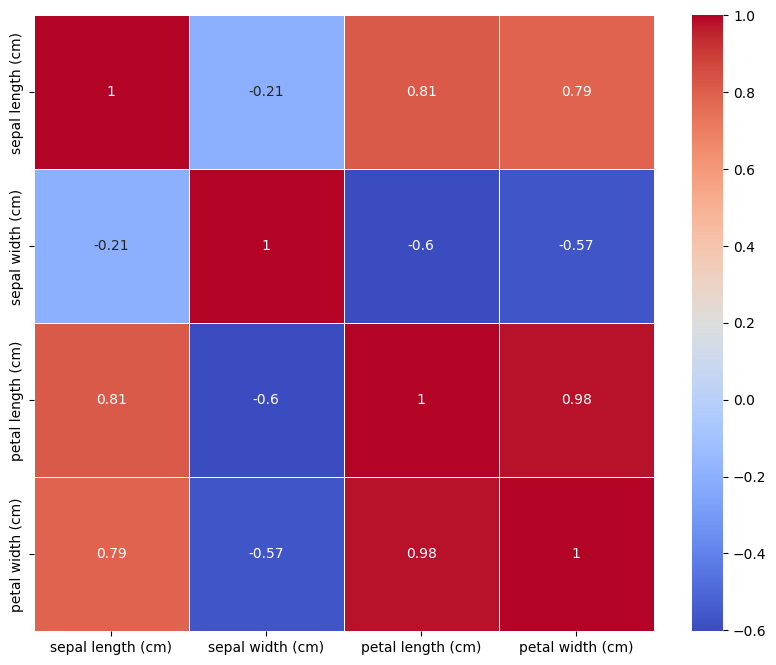

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your dataframe
correlation_matrix = X.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Show the plot
plt.show()

Among the features, the petal length and petal width are highly correlated with each other. The sepal length are also highly correlated with petal length and petal width. This may lead to multicolinearity when building the model

## Train Model

In [5]:
# Train XGBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
model = xgboost.XGBClassifier().fit(X_train, y_train)

In [6]:
features = X_train.columns

## Partial Dependence Plots (PDP)

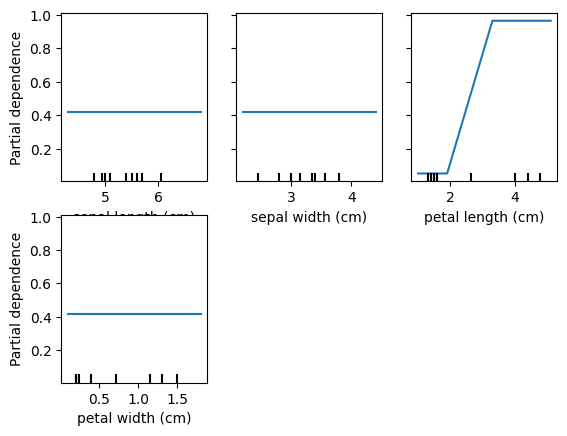

In [7]:
# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average') #kind='both'

According to the PDP plots, the sepal length, sepal width, and petal width are straight line. That means these features do not have any impact on the final prediction. In contrast, petal length first plateaued and then have an increasing linear trend as the petal length increases, then it plateaued again. That means the petal length does not have much impact to the prediction when it's less than 2 cm and laarter than 3.5 cm. As the petal length increases when it's between 2 cm and 3.5 cm, it is more likely to predict the flower as class 1. That means the size of flower is critical to determine the class of the iris.

## ALE Plots

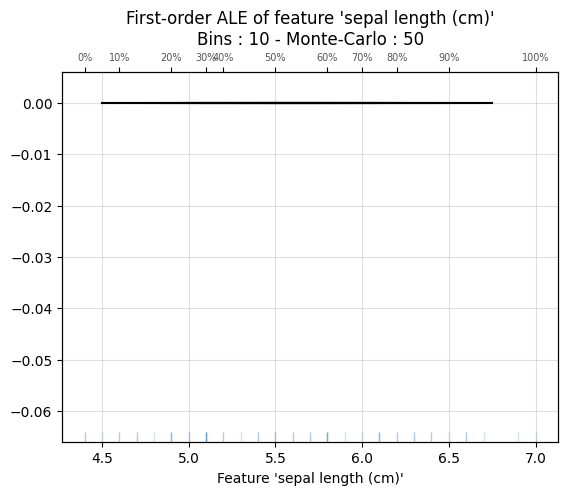

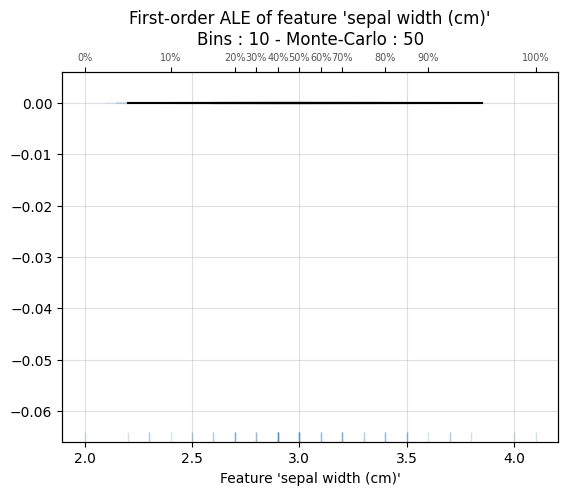

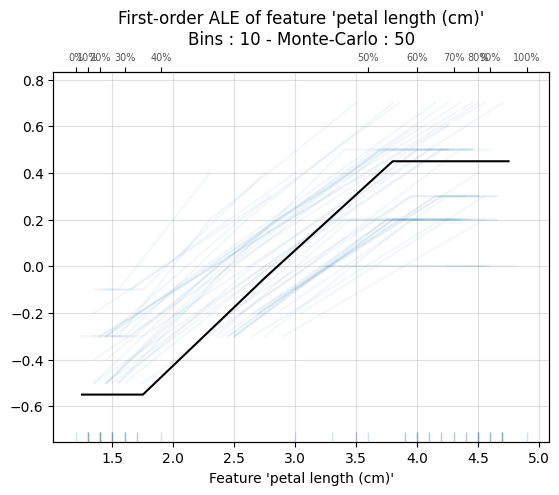

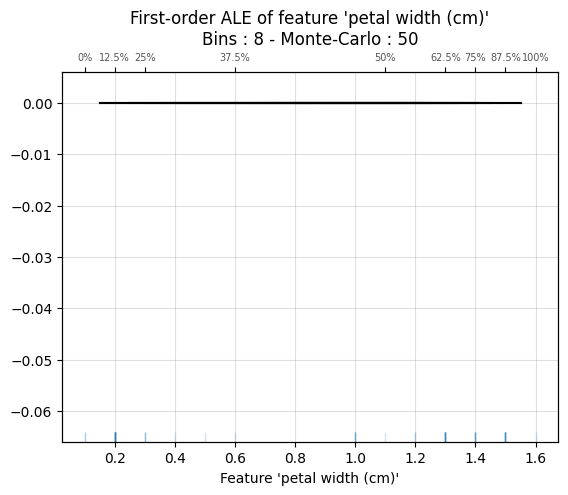

In [10]:
for f in features:
  # Use default parameters for 1D Main Effect ALE Plot
  ale_plot(model, X_train, f, monte_carlo=True)

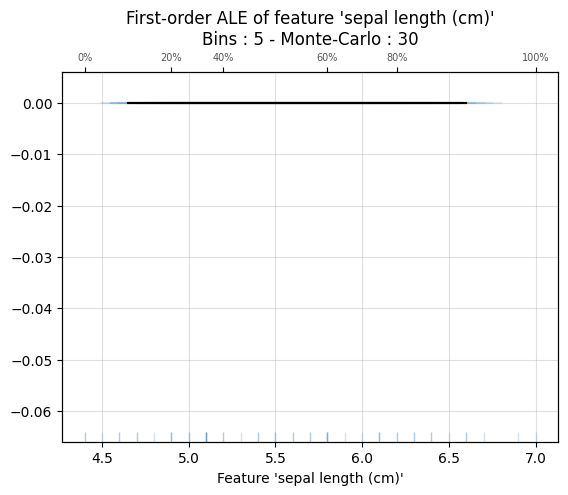

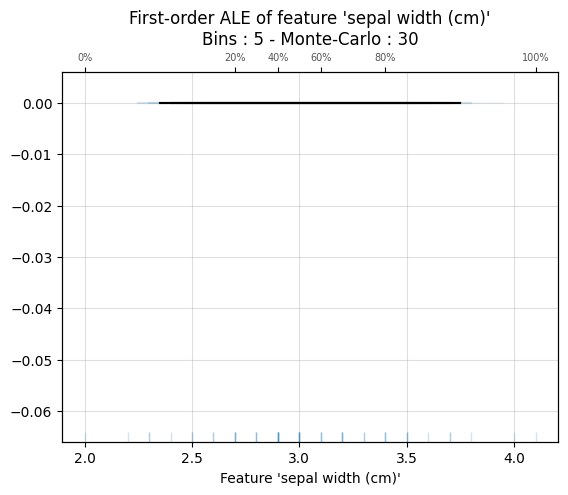

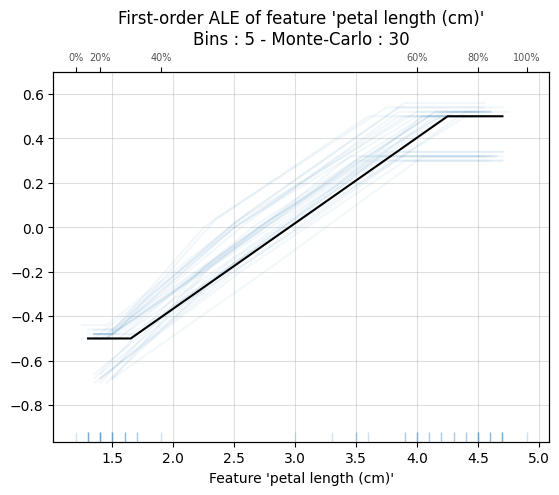

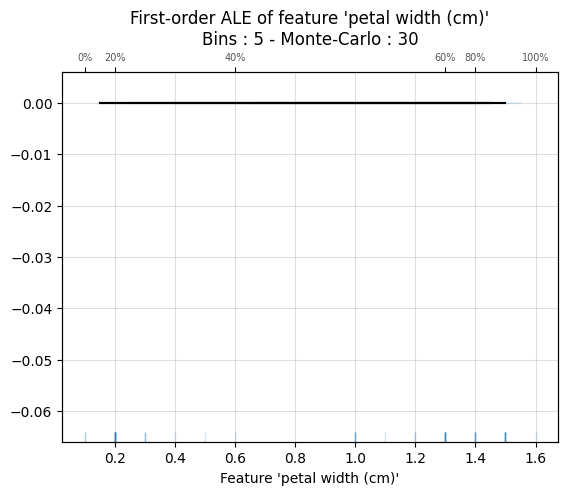

In [11]:

for f in features:
  # Change hyperparameters for 1D Main Effect ALE Plot
  ale_plot(
      model,
      X_train,
      f,
      bins=5,
      monte_carlo=True,
      monte_carlo_rep=30,
      monte_carlo_ratio=0.5,
  )

The result is very similar to PDP plots. Only petal length has impact to the prediction, and there's an increasing linear trend between the petal length and the likelihood of predicting as class 1. However, the plateau range from ALE plot is different from the PDP plot. When the petal length is below 1.7 cm and above 4.1 cm, it does not impact the prediction.

## ICE Plot

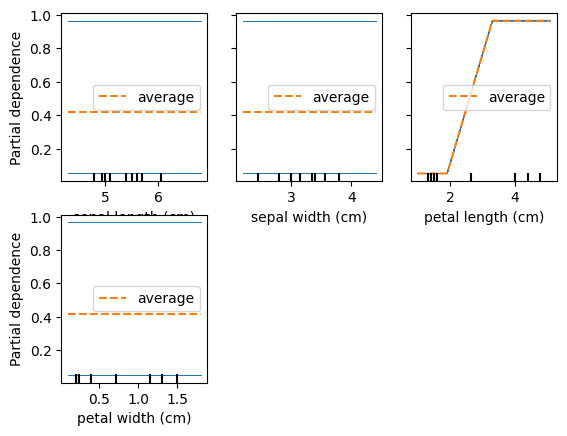

In [18]:
# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both') #kind='both'

The PDP plot and ICE plots overlaps for petal length.